# Credit Card Anomaly Detection Using Unsupervised Techniques

Anomaly detection is the identification of data points, items, observations or events that do not conform to the expected pattern of a given group. These anomalies occur very infrequently but may signify a large and significant threat such as cyber intrusions or fraud. Anomaly detection is heavily used in behavioral analysis and other forms of analysis in order to aid in learning about the detection, identification and prediction of the occurrence of these anomalies.

##### What to expect?

This notebook will extensively cover 10 steps to achieve fraud detection, so sit back and i will try to be as clear as possible.

    1. Algorithm/Model Selection
    2. Data identification and exploration
    3. Data visualization and presentation
    4. Dataset pre-processing
    5. Dataset splitting and training 
    6. Resampling of data in the dataset
    7. Dataset outlier detection using various algorithms (IForest, LOF, COPOD, and DAN)
        7b. Visualization of the outliers and inliers (concentrating more on the outliers)
        7c. Evaluation and metrics
    8. Predicting fraudulent transactions with ‘unseen data’

Let's Go!!!

### 1. Algorithm/Model Selection

Anomaly detection can be approached in many ways depending on the nature of data and circumstances. Following is a classification of some of those techniques (https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/)

A system for anomaly detection should NOT be a supervised ML algorithm as it will (maybe) learn only anomalies it has seen during training. The true magic lies in being able to identify an anomaly never seen before...

Some of the algorithms we will test out are;
- Auto Encoders
- Local Outlier Factor LOF
- COPOD
- Isolation Forest

### 2. Data identification and exploration

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, features from V1 to V28 have been transformed using PCA , the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

##### Import all modules

In [1]:
# Data Processing and Visualiation
import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec

# Modeling
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from pyod.models.copod import COPOD

from imblearn.combine import SMOTETomek, _smote_tomek
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Others
import os
import time
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

2022-08-16 01:07:44.834646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 01:07:44.834750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load Data

df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


As we can see the data has 284,807 observations(rows) and 31 features(columns). Let's break that down a bit

In [3]:
data = df.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data size -> ", data.shape)
print("normal_data -> ", normal_data.shape)
print("fraud_data -> ", fraud_data.shape)
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print("_"*120)

data.head()

data size ->  (284807, 31)
normal_data ->  (284315, 31)
fraud_data ->  (492, 31)
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
________________________________________________________________________________________________________________________


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# A check for Null values!
df.isnull().sum().max()

0

<b>Note</b>: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

### 3. Data visualization and presentation

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

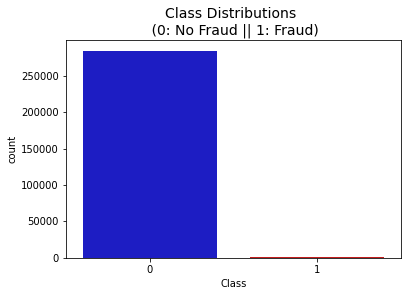

In [5]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Only <b>Time</b> and <b>Amount</b> have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

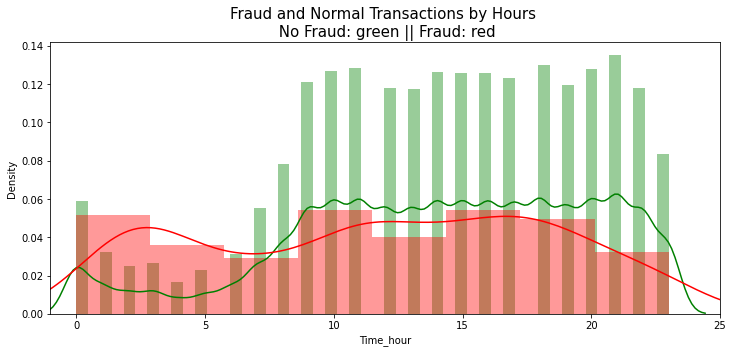

In [6]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours \n No Fraud: green || Fraud: red', fontsize=15)
plt.xlim([-1,25])
plt.show()

From the chart above the hour of day have some impact on number or fraud cases.

### 4. Dataset pre-processing

##### Feature transformation
Lets transform the remaining features in this case 'Time' and 'Amount' using PCA

In [7]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

# V29 and V30 will be the new Time and Amount respectively
df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

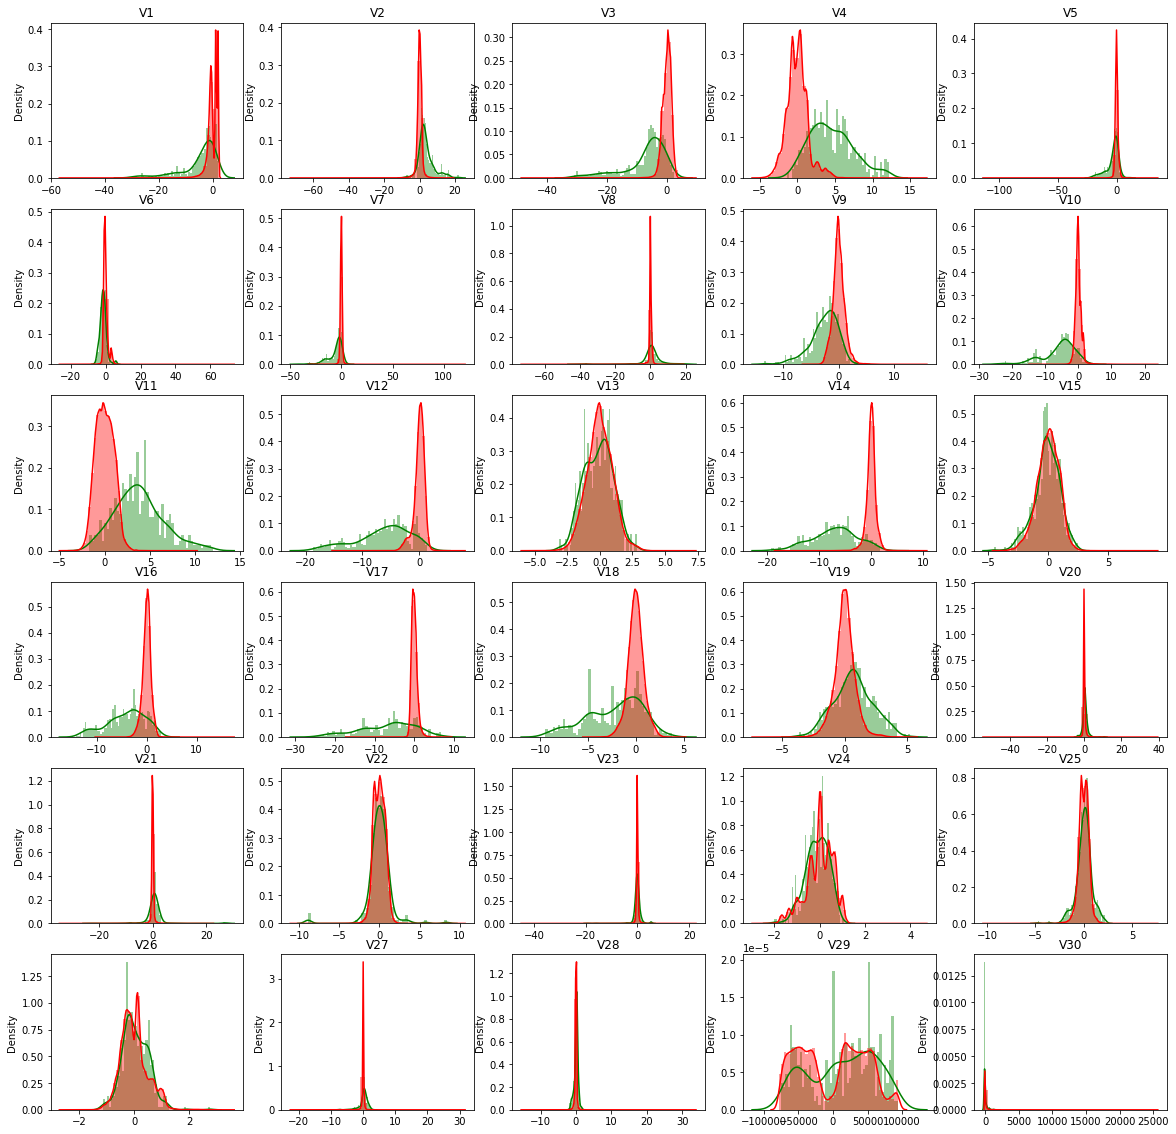

In [8]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

##### Feature Selection using Z-test
Lets move to do some hypothesis testing to find statistically significant features. We will be performing Z-test with valid transactions as our population.

So the case is we have to find if the values of fraud transactions are significantly different from normal transaction or not for all features. The level of significance is 0.01 and its a two tailed test.

<b>Scenario:</b>
- Valid transactions as our population
- Fraud transactions as sample
- Two tailed Z-test
- Level of significance 0.01
- Corresponding critical value is 2.58

<b>Hypothesis:</b>
- H0: There is no difference (insignificant)
- H1: There is a difference (significant)

<b>Formula for z-score:</b>
                                            
                                            Zscore=(x¯−μ)/S.E

In [9]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [10]:
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V14  is statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V24  is statistically significant
V27  is statistically significant
V28  is statistically significant
V29  is statistically significant
V30  is statistically significant


As we have already seen from distribution plots that distribution of normal and fraud data of V13, V15, V22, V23, V25 and 26 features is almost same, now, its proven through hypothesis testing. We will eliminate these features from our dataset as they don't contribute at all.

In [11]:
# Add the class feature back to the significant features only and reassign the dataframe to hold only significant
significant_features.append('Class')
df = df[significant_features]

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V27', 'V28',
       'V29', 'V30', 'Class'],
      dtype='object')


##### Scaling and Distributing
Now we will first scale the columns comprise of Time and Amount. Time and amount should be scaled as the other columns.


In [12]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V18,V19,V20,V21,V24,V27,V28,V29,V30,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,94813.862847,55.978567,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,94813.854647,-90.951433,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,94812.875630,285.018623,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,94812.861389,29.858623,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,94811.858403,-23.651321,0


In [13]:
# Since most of our data has already been scaled
# we should scale the columns that are left to scale - Time(V29) Amount(V30))

std_scaler = StandardScaler()

df['scaled_time'] = std_scaler.fit_transform(df['V29'].values.reshape(-1,1))
df['scaled_amount'] = std_scaler.fit_transform(df['V30'].values.reshape(-1,1))

df.drop(['V29','V30'], axis=1, inplace=True)

In [14]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(21, 'V29', scaled_time)
df.insert(22, 'V30', scaled_amount)

#  Time (V29) and Amount(30) are Scaled!

df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V18,V19,V20,V21,V24,V27,V28,V29,V30,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,1.996583,0.223820,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,1.996583,-0.363652,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,1.996562,1.139593,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,1.996562,0.119384,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,1.996541,-0.094565,0


### 5. Dataset splitting

##### Splitting the Data (Original DataFrame)
In a real-world application, classification modeling often encountered with an imbalanced dataset problem as we have seen in our case, where the number of non-fraud class is much bigger than the fraud class, thus making the model unable to learn from fraud class well.

To achieve this we either to oversample the fraud class or undersample the non-fraud class.

Before proceeding with the Sampling technique we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [15]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
X_train -  (199364, 23)
y_train -  (199364,)
X_test -  (85443, 23)
y_test -  (85443,)


### 6. Resampling of data in the dataset

In a real-world application, classification modeling often encountered with an imbalanced dataset problem as we have seen in our case, where the number of non-fraud class is much bigger than the fraud class, thus making the model unable to learn from fraud class well.
To achieve this we either to oversample the fraud class or undersample the non-fraud class.

##### SMOTE Links

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [16]:
# Oversampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

adasyn = SMOTE(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train_smote = X_res
y_train_smote = y_res

print("X_train - ",X_train_smote.shape)
print("y_train - ",y_train_smote.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199008, 1: 356})
Resampled dataset shape Counter({0: 199008, 1: 199008})
X_train -  (398016, 23)
y_train -  (398016,)
X_test -  (85443, 23)
y_test -  (85443,)


In [17]:
print(y_train_smote.to_frame().value_counts())

Class
0        199008
1        199008
dtype: int64


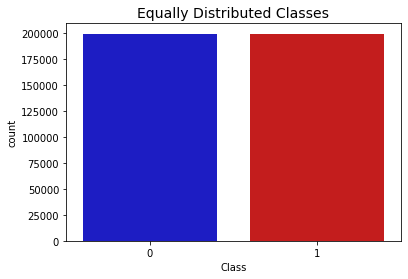

In [18]:
m_data = y_train_smote.to_frame()
sns.countplot('Class', data=m_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

##### ADASYN

ADASYN is a generalized form of the SMOTE algorithm. This algorithm also aims to oversample the minority class by generating synthetic instances for it. But the difference here is it considers the density distribution, ri which decides the no. of synthetic instances generated for samples which difficult to learn. Due to this, it helps in adaptively changing the decision boundaries based on the samples difficult to learn. 

In [19]:
# Oversampling only on train

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train_adasyn = X_res
y_train_adasyn = y_res

print("X_train - ",X_train_adasyn.shape)
print("y_train - ",y_train_adasyn.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Original dataset shape Counter({0: 199008, 1: 356})
Resampled dataset shape Counter({1: 199032, 0: 199008})
X_train -  (398040, 23)
y_train -  (398040,)
X_test -  (85443, 23)
y_test -  (85443,)


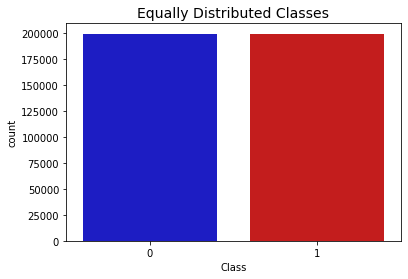

In [20]:
m_data = y_train_adasyn.to_frame()
sns.countplot('Class', data=m_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### 7. Dataset outlier detection using various algorithms (IForest, LOF, COPOD, and DAN)

##### Isolation Forest

In [21]:
# Train with SMOTE data
isofo_smote = IsolationForest()
isofo_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = isofo_smote.predict(X_test)

In [22]:
# Train with ADASYN data
isofo_adasyn = IsolationForest()
isofo_adasyn.fit(X_train_adasyn, y_train_adasyn)

y_pred_adasyn = isofo_adasyn.predict(X_test)

In [23]:
# replace 1 with 0 and -1 with 1
np.place(y_pred_smote, y_pred_smote == 1, 0)
np.place(y_pred_smote, y_pred_smote == -1, 1)

# replace 1 with 0 and -1 with 1
np.place(y_pred_adasyn, y_pred_adasyn == 1, 0)
np.place(y_pred_adasyn, y_pred_adasyn == -1, 1)

In [24]:
print('-------------------SMOTE-------------------')
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred_smote , y_test))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred_smote)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred_smote)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred_smote)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred_smote)))

print('-------------------ADASYN-------------------')
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred_adasyn , y_test))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred_adasyn)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test , y_pred_adasyn)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test , y_pred_adasyn)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred_adasyn)))

-------------------SMOTE-------------------
Accuracy :0.98258
AUC : 0.66092
Precision : 0.03186
Recall : 0.33824
F1 : 0.05823
-------------------ADASYN-------------------
Accuracy :0.98199
AUC : 0.79644
Precision : 0.05290
Recall : 0.61029
F1 : 0.09736


In [25]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [26]:
CM_smote = confusion_matrix(y_test, y_pred_smote)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()

CM_adasyn = confusion_matrix(y_test, y_pred_adasyn)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adasyn).ravel()

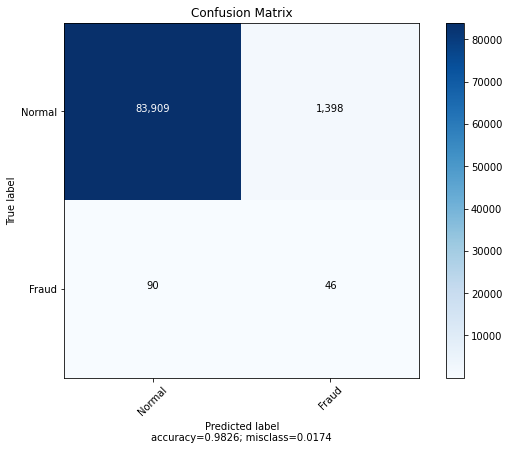

In [27]:
plot_confusion_matrix(CM_smote, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

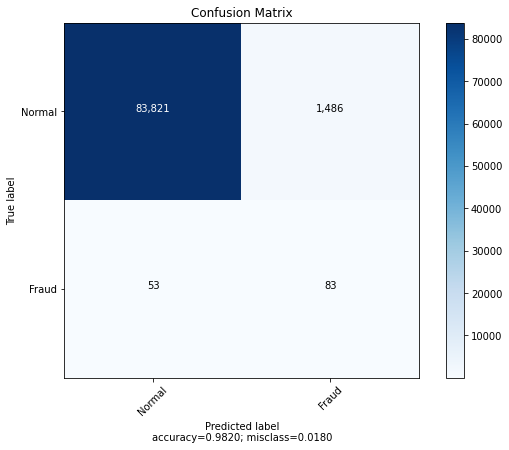

In [28]:
plot_confusion_matrix(CM_adasyn, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

##### Local Outlier Factor (LOF)

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. 

In [29]:
data = df.copy()
all_cols = list(data)[:]
XcopyALL = data[all_cols]
data = np.concatenate((X_train_smote, y_train_smote.to_frame()), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

X_inliers = data.loc[data["Class"] == 0] # Normal Data
X_outliers = data.loc[data["Class"] == 1] # Fraud Data
X = np.r_[X_inliers, X_outliers]


In [30]:
# Train with SMOTE data
lof_smote = LocalOutlierFactor(n_neighbors=20)

y_pred_smote = lof_smote.fit_predict(X)

In [31]:
# replace 1 with 0 and -1 with 1
np.place(y_pred_smote, y_pred_smote == 1, 0) # Positive values are inliers
np.place(y_pred_smote, y_pred_smote == -1, 1) # Negative values are outliers

In [32]:
y_test2 = np.concatenate([np.zeros(199008), np.ones(199008)])

In [33]:
print('-------------------SMOTE-------------------')
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred_smote , y_test2))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_test2 , y_pred_smote)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_test2 , y_pred_smote)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_test2 , y_pred_smote)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_test2 , y_pred_smote)))

-------------------SMOTE-------------------
Accuracy :0.49460
AUC : 0.49460
Precision : 0.43867
Recall : 0.03865
F1 : 0.07104


##### Copula-Based Outlier Detection (COPOD)

Copula-Based Outlier Detection — COPOD — is a new algorithm for anomaly detection. It has been implemented in the PyOD python package.

It has several key features that make it stand out from competing algorithms:
- Deterministic
- No hyperparameters! (This is important because is difficult to tune hyperparameters for outlier detection tasks because the true labels are rare, unknown, or difficult to obtain)
- Top-performance on benchmark anomaly detection datasets
- Interpretable and easy to visualize anomalies
- Fast and computationally efficient
- Scales to high-dimensional datasets

In [34]:
clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train_smote)
test_scores = clf.decision_function(X_test)

from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, precision @ rank n:{prn}')

COPOD ROC:0.9085, precision @ rank n:0.2941


In [35]:
clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train_adasyn)
test_scores = clf.decision_function(X_test)

from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, precision @ rank n:{prn}')

COPOD ROC:0.9417, precision @ rank n:0.3235


##### Deep Autoencoder (DAN)

- The idea is to use the Reconstruction Error as the limit to separate between Normal (low reconstruction error) and Fraud anomalies (high reconstruction errors)
- Reconstruction error is the MSE between the input X_train and the output of the autoencoder which has the same dimensions as X_train.
- Not to be confused with the error between a prediction and the true label

##### ADASYN

In [50]:
input_dim = X_train_adasyn.shape[1]
encoding_dim = 14

In [51]:
# Keras Auto Encoder model

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_4 (Dense)             (None, 14)                336       
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 dense_7 (Dense)             (None, 23)                184       
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [52]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train_adasyn, X_train_adasyn,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
12439/12439 [==============================] - 47s 4ms/step - loss: 3.9593 - accuracy: 0.6480 - val_loss: 0.8568 - val_accuracy: 0.6351
Epoch 2/10
12439/12439 [==============================] - 44s 3ms/step - loss: 3.8041 - accuracy: 0.7281 - val_loss: 0.8399 - val_accuracy: 0.6574
Epoch 3/10
12439/12439 [==============================] - 43s 3ms/step - loss: 3.7874 - accuracy: 0.7509 - val_loss: 0.8268 - val_accuracy: 0.6753
Epoch 4/10
12439/12439 [==============================] - 44s 4ms/step - loss: 3.7799 - accuracy: 0.7611 - val_loss: 0.8203 - val_accuracy: 0.6822
Epoch 5/10
12439/12439 [==============================] - 43s 3ms/step - loss: 3.7746 - accuracy: 0.7651 - val_loss: 0.8055 - val_accuracy: 0.6878
Epoch 6/10
12439/12439 [==============================] - 44s 4ms/step - loss: 3.7667 - accuracy: 0.7694 - val_loss: 0.7977 - val_accuracy: 0.7070
Epoch 7/10
12439/12439 [==============================] - 43s 3ms/step - loss: 3.7632 - accuracy: 0.7765 - val_loss: 0

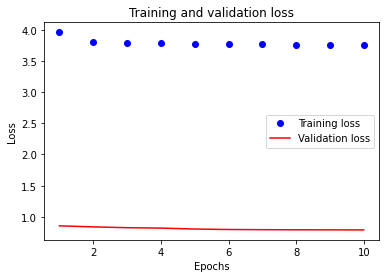

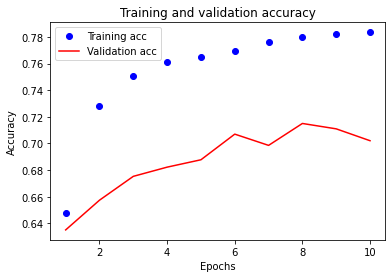

In [53]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
# Load the best model saved above during training

autoencoder = load_model('model.h5')

In [55]:
# Reconstruction error on Train

# As Train has no Fraud
#y_train = np.zeros(X_train.shape[0])

predictions = autoencoder.predict(X_train_adasyn)
predictions.shape

mse = np.mean(np.power(X_train_adasyn - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train_adasyn})
print(error_df.shape[0], ' rows')
print('mean error of recon on TRAIN', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TRAIN', round(error_df.reconstruction_error.std(),2))

12439/12439 [==============================] - 26s 2ms/step
398040  rows
mean error of recon on TRAIN 3.76
std error of recon on TRAIN 13.26


In [56]:
# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

2671/2671 [==============================] - 6s 2ms/step
85443  rows
mean error of recon on TEST 0.79
std error of recon on TEST 3.54


In [57]:
# Reconstruction error on Fraud

pca_columns = list(data)[:-1] # all cols without Class
fraud_data = data.loc[data["Class"] == 1]
fraud_pca_data = fraud_data[pca_columns]

# As Fraud is all Fraud
y_Fraud = np.ones(fraud_pca_data.shape[0])
y_Fraud.shape

predictions = autoencoder.predict(fraud_pca_data)
predictions.shape

mse = np.mean(np.power(fraud_pca_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_Fraud})
print(error_df.shape[0], ' rows')
print('mean error of recon on FRAUD', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on FRAUD', round(error_df.reconstruction_error.std(),2))

6219/6219 [==============================] - 14s 2ms/step
199008  rows
mean error of recon on FRAUD 25.6
std error of recon on FRAUD 36.08


In [58]:
# Predictions on Normal vs Fraud on Test ... using the reconstruction error as the parameter to tweak for best F1

# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

ReconError = 4.0

pred = [1 if e > ReconError else 0 for e in error_df.reconstruction_error.values]
len(pred)
#pred = (x <= eps)
f = f1_score(y_test, pred, average='binary')
print("F1 score on test", round(f,4), " with reconstruction error  ", ReconError)

2671/2671 [==============================] - 6s 2ms/step
85443  rows
mean error of recon on TEST 0.79
std error of recon on TEST 3.54
F1 score on test 0.1358  with reconstruction error   4.0


Optimize the reconstruction error for best F1

In [59]:
minRE = 1
maxRE = 50
    
EpsF1 = []

for TryRE in range(minRE,maxRE):
    pred = [1 if e > TryRE else 0 for e in error_df.reconstruction_error.values]
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([TryRE, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['ReconError', 'F1'])
EpsF1df.head()

,ReconError,F1
0,1,0.0235
1,2,0.0676
2,3,0.1025
3,4,0.1358
4,5,0.1532


In [60]:
# Best Recon Error ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]

ReconError    37.0000
F1             0.3333
Name: 36, dtype: float64

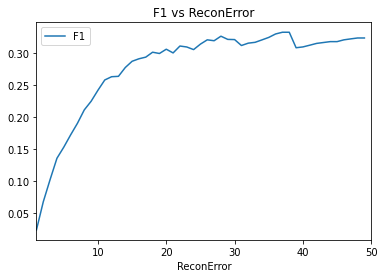

In [61]:
EpsF1df.plot.line("ReconError","F1")
plt.xlim(1, 50)
plt.title("F1 vs ReconError")
plt.show()